*what and why*
## Description

**Is the SARIMA model (see description of the Machine Learning model below) useful for stock prediction? If so, when is it useful?**

This GitHub project utilizes the yfinance library to import historical stock data for Apple Inc. (AAPL), NVIDIA (NVDA), and Tesla (TSLA) . By leveraging this data, SARIMA models were developed for stock price prediction:
 
 **SARIMA Model: Seasonal Autoregressive Integrated Moving Average (SARIMA) model, a time series forecasting method, is implemented to capture the underlying patterns and trends in the stock price data.**

 The Seasonal Autoregressive Integrated Moving Average (SARIMA) model provides a robust framework for predicting stock prices. SARIMA's ability to capture seasonal patterns and cyclic behavior inherent in sequential data, along with its foundation in statistical time series analysis principles, lends credibility to our predictions. The model's interpretable parameters allow for a deeper understanding of the underlying dynamics driving stock price movements. However, it's important to note SARIMA's limitation in capturing external factors such as news events or sudden market shocks, which may impact stock prices but are not directly incorporated into the model. Despite this consideration, SARIMA remains a valuable tool for predicting stock prices based on historical patterns and internal data dynamics.  


Two additional kinds of models were created for the AAPL stock for further analysis:
1. LSTM Model: Long Short-Term Memory (LSTM) neural network model is utilized for its ability to effectively learn from sequential data and capture complex patterns in the stock price dynamics.
2. Combined LSTM and SARIMA Model: A novel approach combining the strengths of both LSTM and SARIMA models is proposed. This hybrid model aims to enhance prediction accuracy by leveraging the complementary capabilities of each model.

## Objective
Discover if it is possible to implement a robust SARIMA model to enable accurate prediction of a client's company stock price, leveraging historical data and market trends. The primary aim is to use the predictive insights to formulate strategic investment decisions aimed at maximizing shareholder profit and optimizing portfolio performance. 

For AAPL, NVDA, and TSLA: Download historical data for the following time ranges and predict stock price for 06-01-2024 to 06-11-2024:

Historical Data Time Ranges:
1. 01-01-2004 to 5-31-2024 
2. 01-01-2010 to 5-31-2024
3. 01-01-2013 to 5-31-2024
4. 01-01-2017 to 5-31-2024
5. 01-01-2019 to 5-31-2024
6. 01-01-2021 to 5-31-2024
7. 01-01-2023 to 5-31-2024


## Summary Findings
To be added

*how*
## Methodology

In [28]:
# install necessary packages on local machine
%pip install yfinance
%pip install stockstats
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pytz
%pip install statistics
%pip install os
%pip install pyarrow
%pip install pandas_gbq
%pip install statsmodels
%pip install tensorflow
%pip install prophet
%pip install plotly
%pip install statsmodels
%pip install scikit-learn
%pip install pmdarima
%pip install prophet

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

In [29]:
# import yahoo finance data
import yfinance as yf
# import stockstats data
from stockstats import StockDataFrame as ss
# import necessary libraries
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import sqlite3
import pickle
from sklearn.metrics import mean_squared_error, r2_score

#import libraries for SARIMA model
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from datetime import date
from prophet import Prophet
import matplotlib.pyplot as graph

/Users/juliawilliams/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download Data for Selected Stock and Time Range (e.g. AAPL)

In [21]:
 # 1: ----- SARIMA MODEL -----
# ask user for stock ticker and print data
stock_select_str = input("Enter stock ticker: ")
# initial load run
stock_data = yf.download(stock_select_str, start = '2024-04-01', end = '2024-05-31', interval = '1d')

### Print Portion of Downloaded Historical Data and Indicators

In [16]:
#apple_ticker = yf.Ticker("AAPL")
#apple_data = yf.download("AAPL", start = '2020-01-01', interval = '1d')
#apple_df = ss.retype(apple_data)
stock_df = ss.retype(stock_data)
stock_data[['stochrsi', 'macd', 'mfi']] = stock_df[['stochrsi', 'macd', 'mfi']]
#print()
print(stock_data.head())
#print(apple_ticker.get_capital_gains)

                  open        high         low       close   adj close  \
Date                                                                     
2024-04-01  171.190002  171.250000  169.479996  170.029999  169.603378   
2024-04-02  169.080002  169.339996  168.229996  168.839996  168.416351   
2024-04-03  168.789993  170.679993  168.580002  169.649994  169.224319   
2024-04-04  170.289993  171.919998  168.820007  168.820007  168.396423   
2024-04-05  169.589996  170.389999  168.949997  169.580002  169.154495   

              volume   stochrsi      macd  mfi  
Date                                            
2024-04-01  46240500        NaN  0.000000  0.5  
2024-04-02  49329500        NaN -0.026699  0.5  
2024-04-03  47691700  100.00000 -0.008902  0.5  
2024-04-04  53704400   68.17781 -0.030555  0.5  
2024-04-05  42055200  100.00000 -0.011436  0.5  


### Connect to Google BigQuery Service

In [1]:

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# Import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# Specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    '...')
project_id = '...'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = '...'
table_id = '...'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# Specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(stock_data, table_path, job_config=load_info)
load_data.result()


'\nSCOPES = [\n    \'https://www.googleapis.com/auth/cloud-platform\',\n    \'https://www.googleapis.com/auth/drive\',\n]\n\n# Import google cloud service account and bigquery\nfrom google.oauth2 import service_account\nfrom google.cloud import bigquery\n\n# Specify google cloud project information\ncredentials = service_account.Credentials.from_service_account_file(\n    \'...\')\nproject_id = \'...\'\nclient = bigquery.Client(project=project_id, credentials=credentials)\ndataset_id = \'...\'\ntable_id = \'...\'\ntable_path = f"{project_id}.{dataset_id}.{table_id}"\n\n# Specify load reqs\nload_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")\nload_data = client.load_table_from_dataframe(stock_data, table_path, job_config=load_info)\nload_data.result()\n'

## Functions


### SARIMA Model Functions

In [4]:

def sarima_forecast(model, df, forecast_date, feature_scaler):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # Make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Concatenate the original DataFrame with forecasted values and confidence intervals
    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    # Inverse transform the scaled values to their original scale
    for column in df_result.columns:
      df_result[column] = feature_scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

In [5]:
def process_model(stock_transformed):
    print("process model \n")
    sarima_model = pm.auto_arima(stock_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequency of the cycle (yearly)
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
    
    return sarima_model

In [6]:
def sarima_metrics(df_result, model):
    print("Calculating metrics...")
    # Print the columns in df_result for debugging
    print("Columns in df_result:", df_result.columns)

    # Ensure that the DataFrame contains the required columns
    required_columns = ['Actual', 'Prediction']
    if not all(col in df_result.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the columns: {required_columns}")

    # Calculate and print AIC and BIC
    aic = model.aic()
    bic = model.bic()
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")

    # Calculate and print RMSE and MSE
    df_result = df_result.dropna()
    mse = ((df_result["Actual"] - df_result["Prediction"]) ** 2).mean()
    rmse = np.sqrt(mse)
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Calculate and print R-squared
    ss_total = ((df_result["Actual"] - df_result["Actual"].mean()) ** 2).sum()
    ss_residual = ((df_result["Actual"] - df_result["Prediction"]) ** 2).sum()
    r_squared = 1 - (ss_residual / ss_total)
    print(f"R-squared: {r_squared}")

    # Calculate p-value (This is approximate, more robust methods available)
    from statsmodels import api as sm
    X = sm.add_constant(df_result["Prediction"])
    model_sm = sm.OLS(df_result["Actual"], X).fit()
    print(f"P-value: {model_sm.pvalues[1]}")

In [7]:
def serialize_deserialize(sarima_model):
    print("serialize \n")
    # Serialize with Pickle and save it as pkl
    with open('sarima_model.pkl', 'wb') as pkl:
        pickle.dump(sarima_model, pkl)

    # Desiarilize the content of the file back into a Python object
    with open('sarima_model.pkl', 'rb') as pkl:
        loaded_model = pickle.load(pkl)

    return loaded_model

In [8]:
def sarima_load(stock_data, feature_scaler):
    # remove any duplicate index
    stock_data = stock_data.loc[~stock_data.index.duplicated(keep='first')]
    # filter only required data
    stock_data = stock_data[['Close']]
    # transform current stock data
    stock_transformed = pd.DataFrame(np.squeeze(feature_scaler.fit_transform(stock_data), axis=1), columns=["Close"], index=stock_data.index)
    # call function to fit a seasonal ARIMA model
    sarima_model = process_model(stock_transformed)
    # call function to serialize / deserialize SARIMA model with pickle
    sarima_model = serialize_deserialize(sarima_model)
    return stock_transformed, sarima_model

### LSTM Model Functions (Additional Analysis)

In [ ]:
# LSTM functions

def features_targets(data, feature_length):
    # feature length is the number of time steps in the input sequence
    # targets are the values the model is trying to forecast
    time_step_list, close_label_list = [], []
    
    # iterate through (length of sequential data) to (length of seq data - feature length)
    for i in range(len(data) - feature_length):
        # this will get the vals leading up to the target
        time_steps = data[i : i + feature_length]
        time_step_list.append(time_steps)
        # this will get the target val at this point
        labels = data[i + feature_length]
        close_label_list.append(labels)

    # reshape lists to be suitable for network algo
    time_step_list = np.array(time_step_list).reshape(len(time_step_list), feature_length, 1)
    close_label_list = np.array(close_label_list).reshape(len(close_label_list), 1)

    return time_step_list, close_label_list

In [ ]:
def create_model(X, Y, df, data, train_test_slice, scaler):
    # training set: set to train the machine learning model
    # testing set: set used to test model after model has been trained
    # train set is 70% of data, test set is the rest (30%)
    X_train, X_test = X[:-train_test_slice], X[-train_test_slice:]
    Y_train, Y_test = Y[:-train_test_slice], Y[-train_test_slice:]

    # initialize empty model where nodes have input and output with Keras
    model = Sequential()
    # create a bidirectional LSTM: 
    # - 100 cells
    # - return output for input
    # - reduce overfitting w current dropout
    # - specify # of steps for target
    model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1, input_shape=(X_train.shape[1], 1))))
    # provide additional processing with undirectional layer
    model.add(LSTM(50, recurrent_dropout=0.1))
    # add dropout and dense layers
    # randomly sets 20% of inputs to 0 to prevent overfitting
    model.add(Dropout(0.2))
    # create a connected layer with 25 output units
    model.add(Dense(20, activation='elu'))
    model.add(Dropout(0.2))
    # create a connected layer with 10 output units
    model.add(Dense(10))
    # create a connected layer with 1 output unit
    model.add(Dense(1))

    # optimize model using stochastic gradient descent to train model
    # SGD 
    optimize = tf.keras.optimizers.SGD(learning_rate = 0.002)
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimize)
    # save model weights validation loss improves
    weights = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)
    # adjust learning rate when needed
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=0.00001, verbose=1)

    # one epoch completes when the entire training dataset is processed once by the model
    model.fit(X_train, Y_train, epochs=12, batch_size=1, verbose=1, shuffle=False, validation_data=(X_test, Y_test), callbacks=[reduce_lr, weights])
    actual = scaler.inverse_transform(Y_test)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = np.squeeze(actual, axis=1)
    predictions = np.squeeze(predictions, axis=1)

    #reassign index before it goes into model
    test_df = pd.DataFrame({'Actual': actual, 'Predicted': predictions.flatten()})
    print(test_df)
    #return model, loss, predict, predict_inv, Y_test, scaler

    '''
    # Plotting test set
    graph.plot(df.index[-train_test_slice:], predictions, label="Predicted")
    graph.plot(df.index[-train_test_slice:], actual, label="Actual")
    graph.xlabel('Date')
    graph.ylabel('Stock Price')
    graph.legend()
    graph.savefig('predicted_stock_prices_lstm3_test.png')
    graph.show()
    '''
    return model, X_train, X_test, Y_train, Y_test

In [ ]:
def predict_lstm(model, df, future_date, scaler, feature_length=20):
    # iterate through today's date until future date
    for i in range((datetime.strptime(future_date, '%Y-%m-%d') - df.index[-1]).days):
        # specify close values
        feature_column = df['Close'].values
        # pick out last 20 days
        time_steps = feature_column[-feature_length:]
        # reshape array
        time_steps = time_steps.reshape(feature_length, 1)
        # scale array
        time_steps = scaler.transform(time_steps)
        prediction = model.predict(time_steps.reshape(1, feature_length, 1))
        prediction = scaler.inverse_transform(prediction)
        # concatenate results with og dataframe
        df_forecast = pd.DataFrame(prediction, index=[df.index[-1] + timedelta(days=1)], columns=['Close'])
        df = pd.concat([df, df_forecast])
    return df

In [10]:
def create_plot(test):
    print("create plot \n")
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(test["Actual"][-120:], color='#1f76b4')
    plt.plot(test["Prediction"], color='darkgreen')
    plt.fill_between(test.index,
                test["Low"],
                test["High"],
                color='k', alpha=.15)

    plt.title("SARIMA - Forecast of AAPL Stock Price")
    plt.show()

## Step 1: SARIMA Model for AAPL Stock


(EXAMPLE) Predict stock share price for AAPL stock with historical time range 01-01-2023 to 05-31-2024:

[*********************100%%**********************]  1 of 1 completed
process model 

serialize 

initial load returned
            Actual  Prediction         Low        High
2024-06-01     NaN  194.351159  186.880271  201.822048
2024-06-02     NaN  193.117363  183.980027  202.254699
2024-06-03     NaN  191.182728  180.718121  201.647335
2024-06-04     NaN  191.650518  180.076194  203.224842
2024-06-05     NaN  195.314035  182.785851  207.842219
2024-06-06     NaN  193.509610  180.146707  206.872514
2024-06-07     NaN  191.498699  177.396109  205.601288
2024-06-08     NaN  192.495259  177.731092  207.259426
2024-06-09     NaN  193.143760  177.783648  208.503872
2024-06-10     NaN  192.887954  176.987988  208.787921
2024-06-11     NaN  194.374490  177.983246  210.765733
create plot 



/Users/juliawilliams/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/juliawilliams/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


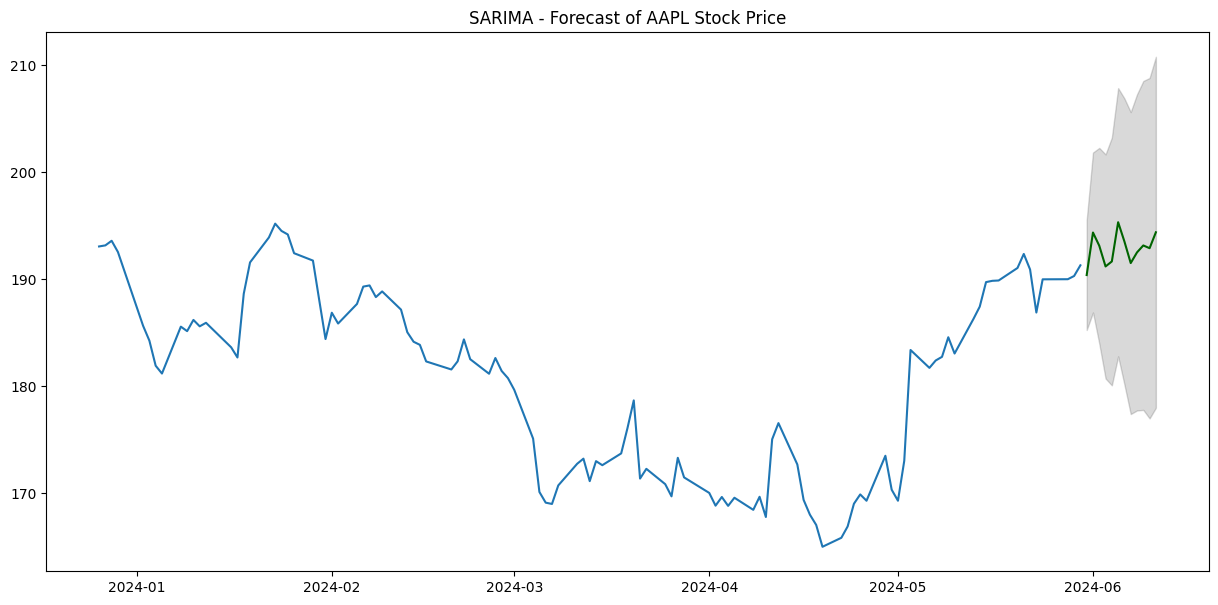

2023-01-03    125.070000
2023-01-04    126.360001
2023-01-05    125.019997
2023-01-06    129.619995
2023-01-09    130.149994
                 ...    
2024-06-07           NaN
2024-06-08           NaN
2024-06-09           NaN
2024-06-10           NaN
2024-06-11           NaN
Name: Actual, Length: 366, dtype: float64


ValueError: x, y, and format string must not be None

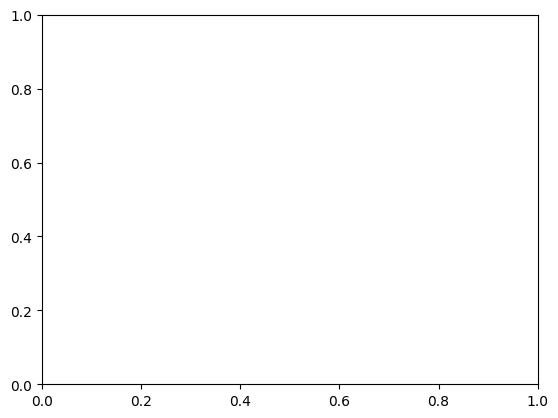

In [32]:
# 1: ----- SARIMA MODEL ----- (INITIAL LOAD)
# ask user for stock ticker and print data
stock_select_str = input("Enter stock ticker: ")
stock_data = yf.download(stock_select_str, start = '2023-01-01', end = '2024-05-31', interval = '1d')
# scale data
feature_scaler = MinMaxScaler()
# run SARIMA functions for initial load
initial_transformed, initial_model = sarima_load(stock_data, feature_scaler)
print("initial load returned")
# forecast initial load
initial_df_pred_sarima = sarima_forecast(initial_model, initial_transformed, '2024-06-11', feature_scaler)
#print_metrics(initial_transformed, initial_model)
print(initial_df_pred_sarima.tail(11))
#print(initial_df_pred_sarima)
plot = create_plot(initial_df_pred_sarima)
print(initial_df_pred_sarima["Actual"])
actual = initial_df_pred_sarima["Actual"]
graph.plot(plot, label = "total predict")
graph.plot(actual, label = "total actual")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
#graph.savefig('predicted_stock_prices_lstm_total.png')
graph.savefig('test1.png')
graph.show()


### SARIMA model plot diagnostics plot

### SARIMA plot

## Step 2: LSTM
*why?*  

LSTM MODEL:

In [ ]:
#apple_data = yf.download("AAPL", start = "2020-01-01", interval = '1d')
apple_df_test = apple_data.reset_index()
apple_df = apple_df_test.copy()

In [ ]:
scaler = MinMaxScaler()
data_transformed = pd.DataFrame(
    np.squeeze(
        scaler.fit_transform(
            apple_df[["Close"]])), columns=["Close"], index=apple_df.index)

In [ ]:
time_step_vals, target_vals = features_targets(data_transformed["Close"].values, 20)

In [ ]:
train_vals_cutoff = apple_df.loc[apple_df['Date'] >= '2022-01-01']
slice = train_vals_cutoff.shape[0]


In [ ]:
model, X_train, X_test, Y_train, Y_test = create_model(
        time_step_vals, target_vals, apple_df, data_transformed["Close"].values, slice, scaler)

In [ ]:
total_x = np.concatenate((X_train, X_test), axis = 0)
total_y = np.concatenate((Y_train, Y_test), axis = 0)
final_predict = model.predict(total_x)
final_predict = scaler.inverse_transform(final_predict)
actual = scaler.inverse_transform(total_y)
final_predict = np.squeeze(final_predict, axis = 1)
actual = np.squeeze(actual, axis = 1)

### LSTM plot

In [ ]:
graph.plot(final_predict, label = "total predict")
graph.plot(actual, label = "total actual")
graph.xlabel('Date')
graph.ylabel('Stock Price')
graph.legend()
graph.savefig('test.png')
graph.show()

In [ ]:
model.predict(data_transformed[-21:-1].values.reshape(1,20,1))
data = pd.DataFrame(apple_data)
test = predict_lstm(model, data, '2024-02-01', scaler)

In [ ]:
test.tail()

# Q: is this where the combo assessment goes?

# Q: Why does SARIMA only have 1 function, but LSTM has several?

# Q: do you want to output plots as pngs?

## Write to file

In [ ]:

# specify google cloud project information
dataset_id = 'predicted_prices'
table_id = 'SARIMA and LTSM Predicted Prices'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
# enter combined data load_data = client.load_table_from_dataframe(combined data, table_path, job_config=load_info)
load_data.result()

## Summary
** a bit more detail about why a client would need this and what value it would bring to their work **